In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Read file
icfes = pd.read_csv("./data/icfes_preprocessing.csv", low_memory=False, encoding="utf-8")

print(icfes.shape)

(554679, 67)


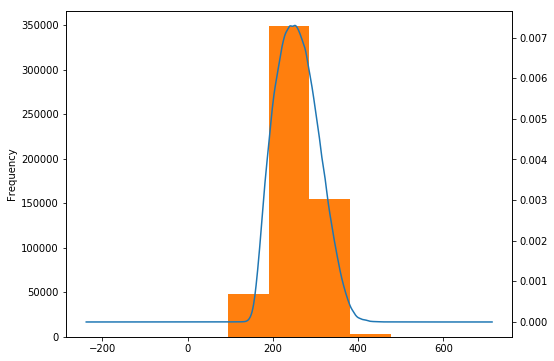

In [3]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
column = icfes['PUNT_GLOBAL']

column.plot.density(ax=ax1, secondary_y=True)

column.plot.hist(bins=5, ax=ax1)

plt.show()

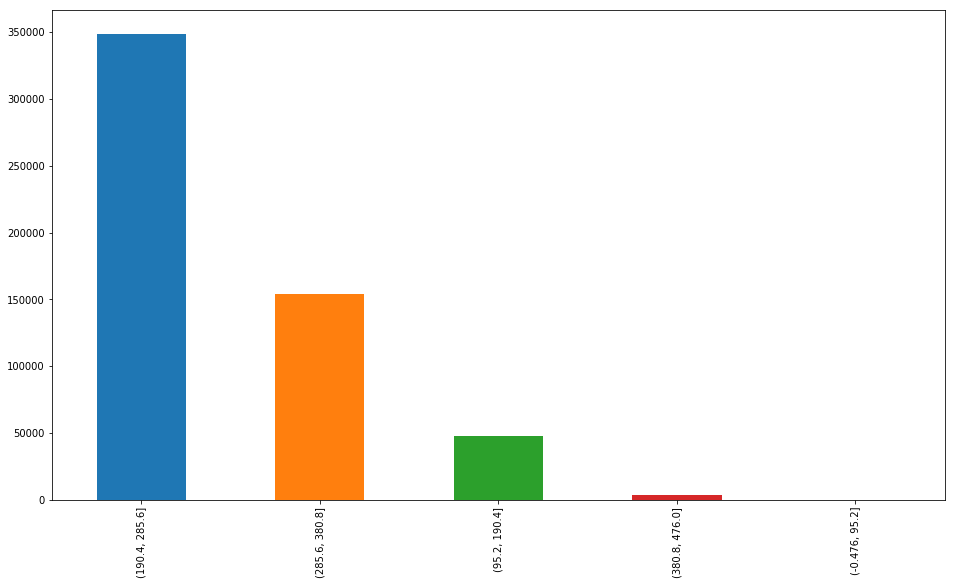

In [4]:
pg = pd.cut(icfes['PUNT_GLOBAL'], bins=5)

plt.figure(figsize=(16, 9))
pg.value_counts(dropna=False).plot.bar()

# Preprocessing

In [107]:
import math
from sklearn import preprocessing

m = math.ceil(icfes.shape[0]*1.0)

data = icfes.iloc[0: m, :]

n = data.shape[1]

X = data.drop(columns='PUNT_GLOBAL')
y = data['PUNT_GLOBAL']

print(data.shape)


# Remove unused columns
X = X.drop(columns=['PERCENTIL_C_NATURALES',
                    'PERCENTIL_GLOBAL',
                    'PERCENTIL_INGLES',
                    'PERCENTIL_LECTURA_CRITICA',
                    'PERCENTIL_MATEMATICAS',
                    'PERCENTIL_SOCIALES_CIUDADANAS'])
X = X[X.columns[X.columns.to_series().str.contains('FAMI')]]

# One-hot enconding
X = pd.get_dummies(X)
X_labels = X.columns
X = X.values

# Discretization
y = pd.cut(y, bins=5).astype(str)


# Enconding
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
y = pd.DataFrame(y)
y_labels = le.classes_

y.describe(include='all')

y.info()

y = y.values

print(X.shape)
print(y.shape)

y_labels

(554679, 67)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554679 entries, 0 to 554678
Data columns (total 1 columns):
0    554679 non-null int64
dtypes: int64(1)
memory usage: 4.2 MB
(554679, 124)
(554679, 1)


array(['(-0.476, 95.2]', '(190.4, 285.6]', '(285.6, 380.8]',
       '(380.8, 476.0]', '(95.2, 190.4]'], dtype=object)

In [108]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X, y)

print(clf_tree.predict(X[4:8]))

print(y[4:8].reshape(1, -1))

[2 2 2 1]
[[2 2 2 1]]


In [109]:
import graphviz
import pydot

# Plot tree
dot_file = 'tree.dot'
dot_data = tree.export_graphviz(clf_tree, out_file=dot_file, 
                                feature_names=X_labels,  
                                class_names=y_labels,
                                max_depth = 4,
                                filled=True, proportion=True, rounded=True) 
graph = graphviz.Source(dot_data) 

(g,) = pydot.graph_from_dot_file(dot_file)
g.write_svg('tree.svg')

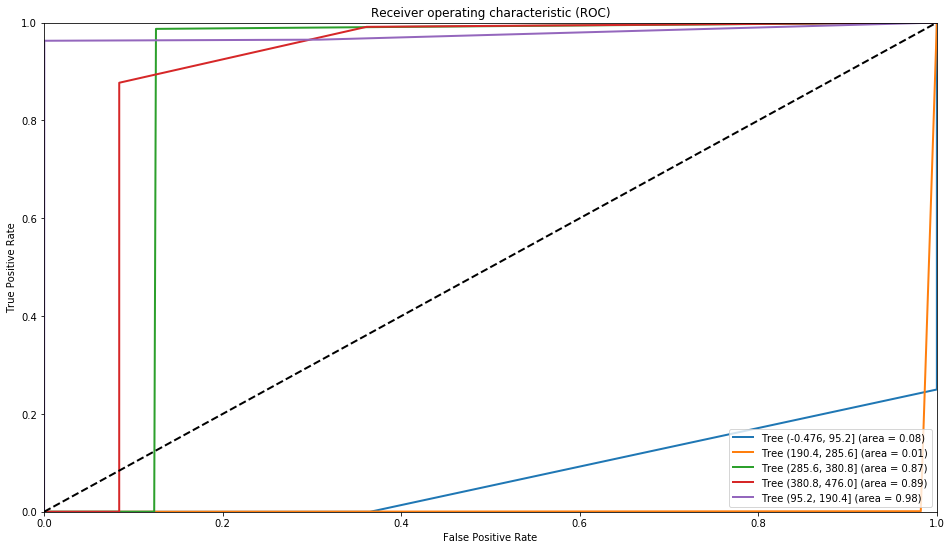

In [111]:
from sklearn.metrics import roc_curve, auc
# ROC
y_pred = clf_tree.predict(X)

fprs = []
tprs = []
aucs = []
for i in np.unique(y):
    fpr, tpr, thresholds = roc_curve(y, y_pred, pos_label=i)
    roc_auc = auc(fpr, tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

# Plot ROC
plt.figure(figsize=(16, 9))
lw = 2
for label, fpr, tpr, auc in zip(y_labels, fprs, tprs, aucs):
    plt.plot(fpr, tpr,
         lw=lw, label='Tree {} (area = {:0.2f})'.format(label, auc))

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
